In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchmetrics

import scipy.interpolate

In [2]:
from pathlib import Path
log_dir = Path('logs/')

In [17]:
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


class OfdmDataset(Dataset):
    def __init__(self, size, bit_count):
        self.size = size
        self.class_count = 2 ** bit_count
        # self.data = torch.randint(0, self.class_count, (size, 55))
    
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        sample = torch.randint(0, self.class_count, (55,))
        return F.one_hot(sample, num_classes=self.class_count).float()
    
ofdm_train_dataset = OfdmDataset(1024, 4)
dataloader = DataLoader(ofdm_train_dataset, batch_size=64, pin_memory=True)

In [18]:
from ml_modulation.modules.qam import QamModulator, QamEncoder, QamDecoder

In [19]:
from ml_modulation.modules.noise import AwgnNoise
from torchinterp1d import Interp1d

import tqdm

class ComplexAwgnNoise(pl.LightningModule):
    def __init__(self, snr):
        super().__init__()
        self.awgn = AwgnNoise(snr)

    def forward(self, x, multiplier):
        noised_real = self.awgn(x.real, multiplier)
        noised_imag = self.awgn(x.imag, multiplier)
        return noised_real + 1j * noised_imag
    
    
class ComplexNormalization(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x / torch.sqrt((x.abs() ** 2).mean())
    

class QamOfdmEncoder(nn.Module):
    def __init__(self, bit_count):
        super().__init__()
        self.qam = QamEncoder(bit_count)
        
    def forward(self, x):
        B, C, W = x.shape
        real = self.qam(x.view(B * C, -1)).view(B, C, 2)
        comp = real[:, :, 0] + 1j * real[:, :, 1]
        return comp

class QamOfdmDecoder(nn.Module):
    def __init__(self, bit_count):
        super().__init__()
        self.qam = QamDecoder(bit_count)
        
    def forward(self, x):
        B, N = x.shape
        real_sample = torch.stack([x.real, x.imag], dim=2).view(-1, 2)
        return self.qam(real_sample).view(B, N, -1)

    
class NNOfdmEncoder(pl.LightningModule):
    def __init__(self, bit_count):
        super().__init__()
        class_count = 2 ** bit_count
        self.encoder = nn.Sequential(
            nn.Linear(class_count, 4 * class_count),
            nn.ReLU(),
            nn.Linear(4 * class_count, 2)
        )
        
    def forward(self, x):
        B, C, W = x.shape
        real_output = self.encoder(x.float().view(B * C, W)).view(B, C, 2)
        return real_output[:, :, 0] + 1j * real_output[:, :, 1]
    
    
class NNOfdmDecoder(pl.LightningModule):
    def __init__(self, bit_count):
        super().__init__()
        class_count = 2 ** bit_count
        self.decoder = nn.Sequential(
            nn.Linear(2, 4 * class_count),
            nn.ReLU(),
            nn.Linear(4 * class_count, class_count)
        )

    def forward(self, x):
        B, N = x.shape
        real_input = torch.stack([x.real, x.imag], dim=2).view(-1, 2)
        return self.decoder(real_input).view(B, N, -1)

class NoNoise(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x, y):
        return x

class OfdmChannel(pl.LightningModule):
    def __init__(self, snr):
        super().__init__()
        self.register_buffer('response', torch.tensor([[[0.3+0.3j, 0, 1]]]))
        # self.response = torch.tensor([[[0.3+0.3j, 0, 1]]], device=self.device)
        # self.awgn = ComplexAwgnNoise(snr)
        self.awgn = NoNoise()
    
    def forward(self, signal):
        # response = torch.tensor([[[0.3+0.3j, 0, 1]]], device=self.device)
        # signal3d = signal.unsqueeze(1)
        # convolved = F.conv1d(signal3d, self.response, padding=torch.numel(self.response) - 1)
        convolved = signal
        signal_power = (convolved ** 2).abs().mean()
        return self.awgn(convolved.squeeze(), signal_power)
    
class Equalizer(pl.LightningModule):
    def __init__(self, pilots, pilot_value, payload_size):
        super().__init__()
        self.register_buffer('pilot_positions', pilots)
        self.register_buffer('all_positions', torch.arange(payload_size))
        # self.all_positions = torch.arange(payload_size, device=self.device)
        self.pilot_value = pilot_value
        self.interp = Interp1d()
        
    def forward(self, x):
        pilots = x[:, self.pilot_positions]
        pilot_estimates = pilots / self.pilot_value
        abs_estimate = self.interp(self.pilot_positions, torch.abs(pilot_estimates), self.all_positions)[0]
        angle_estimate = self.interp(self.pilot_positions, torch.angle(pilot_estimates), self.all_positions)[0]
        estimate = abs_estimate * torch.exp(1j * angle_estimate)
        return x / estimate
    
class Ofdm(pl.LightningModule):
    @classmethod
    def from_autoencoder(cls, path, snr):
        ofdm = cls(NNOfdmEncoder(4), NNOfdmDecoder(4), snr)
        
    
    def __init__(self, modulator, demodulator, snr):
        super().__init__()
        self.subcarriers = 64
        self.cp = 16
        self.register_buffer('pilots', torch.tensor([0, 8, 16, 24, 32, 40, 48, 56, 63]))
        # self.pilots = torch.tensor([0, 8, 16, 24, 32, 40, 48, 56, 63], device=self.device)
        self.register_buffer('data_carriers', torch.tensor([x for x in range(64) if x not in self.pilots]))
        # self.data_carriers = torch.tensor([x for x in range(64) if x not in self.pilots], device=self.device)
        self.pilot_value = 3 + 3j
        self.modulator = modulator
        self.normalizer = ComplexNormalization()
        self.channel = OfdmChannel(snr)
        self.demodulator = demodulator
        self.equalizer = Equalizer(self.pilots, self.pilot_value, self.subcarriers)
        
        self.loss_function = nn.CrossEntropyLoss()
    
    def forward(self, messages):
        B, C, M = messages.shape
        freq_signal = torch.full((B, self.subcarriers), self.pilot_value, dtype=torch.complex64, device=self.device)
        freq_signal[:, self.data_carriers] = self.modulator(messages)
        time_signal = torch.fft.ifft(freq_signal)
        padded_time_signal = torch.hstack([time_signal[:, -self.cp:], time_signal])
        transmitted = self.channel(padded_time_signal)
        received = transmitted[:, self.cp:(self.cp + self.subcarriers)]
        received_freq = torch.fft.fft(received)
        equalized = self.equalizer(received_freq)[:, self.data_carriers]
        demodulated = self.demodulator(equalized)
        return demodulated
    
    @torch.no_grad()
    def constellation(self):
        self.eval()
        batch = F.one_hot(torch.arange(16)).unsqueeze(0).to(self.device)
        outputs = self.normalizer(self.modulator(batch)).squeeze()[:16]
        return outputs
    
    @torch.no_grad()
    def outputs(self):
        self.eval()
        batch = F.one_hot((torch.arange(110) % 16).reshape(2, 55)).to(self.device)
        B, C, M = batch.shape
        freq_signal = torch.full((B, self.subcarriers), self.pilot_value, dtype=torch.complex64, device=self.device)
        freq_signal[:, self.data_carriers] = self.normalizer(self.modulator(batch))
        time_signal = torch.fft.ifft(freq_signal)
        padded_time_signal = torch.hstack([time_signal[:, -self.cp:], time_signal])
        transmitted = self.channel(padded_time_signal)
        received = transmitted[:, self.cp:(self.cp + self.subcarriers)]
        received_freq = torch.fft.fft(received)
        equalized = self.equalizer(received_freq)[:, self.data_carriers][0, :16]
        return equalized
    
    @torch.no_grad()
    def no_noise_outputs(self):
        self.eval()
        batch = F.one_hot((torch.arange(110) % 16).reshape(2, 55)).to(self.device)
        print(batch[:, :5])
        B, C, M = batch.shape
        freq_signal = torch.full((B, self.subcarriers), self.pilot_value, dtype=torch.complex64, device=self.device)
        freq_signal[:, self.data_carriers] = self.normalizer(self.modulator(batch))
        time_signal = torch.fft.ifft(freq_signal)
        padded_time_signal = torch.hstack([time_signal[:, -self.cp:], time_signal])
        transmitted = padded_time_signal
        received = transmitted[:, self.cp:(self.cp + self.subcarriers)]
        received_freq = torch.fft.fft(received)
        equalized = self.equalizer(received_freq)[:, self.data_carriers][0, :16]
        return equalized
        
    @torch.no_grad()
    def measure_error(self, dataloader, repeat=10):
        self.eval()
        correct = 0
        total = 0
        for _ in range(repeat):
            for batch in dataloader: # B * C * 2 ^ bit_count
                decoded = self(batch)
                prediction = decoded.argmax(-1)
                true_classes = batch.argmax(-1)

                correct += (prediction == true_classes).detach().cpu().sum().item()
                total += batch.shape[0] * batch.shape[1]
        return 1 - correct / total
    
    def test_snrs(self, dataloader, snrs):
        old_noise = self.channel
        result = {}
        for snr in tqdm.tqdm(snrs, position=0, leave=True):
            self.channel = OfdmChannel(snr)
            error = self.measure_error(dataloader)
            result[snr] = error
        self.channel = old_noise
        return result
    
    def training_step(self, batch, batch_idx):
        predictions = self(batch)
        loss = self.loss_function(predictions, batch)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [20]:
from pytorch_lightning.loggers import CSVLogger

device_id = 0
device = torch.device(f'cuda:{device_id}')
snr = 8.
nn_ofdm = Ofdm(NNOfdmEncoder(4).to(device), NNOfdmDecoder(4).to(device), snr).to(device)
qam_ofdm = Ofdm(QamOfdmEncoder(4), QamOfdmDecoder(4), snr)
logger = CSVLogger(save_dir=log_dir)

trainer = pl.Trainer(max_epochs=100, logger=logger, gpus=[device_id])
trainer.fit(nn_ofdm, train_dataloaders=dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]

  | Name          | Type                 | Params
-------------------------------------------------------
0 | modulator     | NNOfdmEncoder        | 1.2 K 
1 | normalizer    | ComplexNormalization | 0     
2 | channel       | OfdmChannel          | 0     
3 | demodulator   | NNOfdmDecoder        | 1.2 K 
4 | equalizer     | Equalizer            | 0     
5 | loss_function | CrossEntropyLoss     | 0     
-------------------------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [12]:
print(qam_ofdm.measure_error(dataloader))
print(nn_ofdm.measure_error(dataloader))

0.0
0.5003835227272727


In [24]:
path = Path('../new_model_storage/ae_awgn_16_16.0_50000.pt)
pretrained_nn = Ofdm.from_autoencoder(path, )

SyntaxError: EOL while scanning string literal (3519857373.py, line 1)

100%|█████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]

{5: 0.21993075284090913, 6: 0.17724786931818182, 7: 0.13966619318181817, 8: 0.1099378551136364, 9: 0.08440873579545449, 10: 0.06615056818181819, 11: 0.050877130681818206, 12: 0.040385298295454564, 13: 0.03133345170454549, 14: 0.02517755681818179}


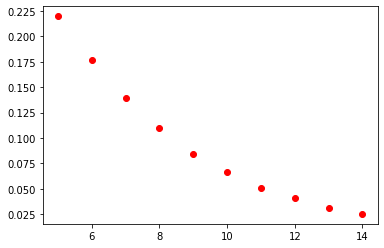

In [58]:
snrs = range(5, 15)
result = qam_ofdm.test_snrs(dataloader, snrs)
print(result)
for x, y in result.items():
    plt.scatter(x, y, color='r')

In [15]:
# qam_ofdm = Ofdm(QamOfdmEncoder(4), QamOfdmDecoder(4), 28.)
# qam_ofdm.measure_error(dataloader)

0.0

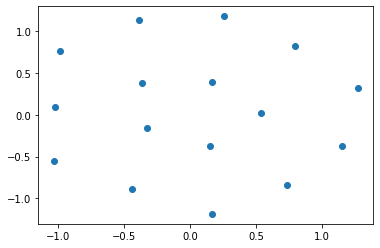

In [59]:
cons = nn_ofdm.constellation()
# for x, y in zip(cons.real[:6], cons.imag[:6]):
#     plt.scatter(x, y)
plt.scatter(cons.real, cons.imag)

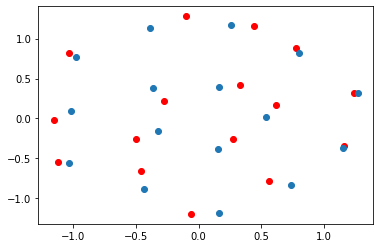

In [60]:
outputs = nn_ofdm.outputs()
doubled = outputs
plt.scatter(outputs.real, outputs.imag, c='r')
plt.scatter(cons.real, cons.imag)
# for x, y in zip(doubled.real[:6], doubled.imag[:6]):
#     plt.scatter(x, y)

In [374]:
nn_ofdm.demodulator(outputs.unsqueeze(0)).argmax(-1)

tensor([[ 9,  1,  2,  8,  9,  1,  8,  8,  3,  3, 11, 11,  3,  3, 11, 11]])

In [372]:
outputs.unsqueeze(0)

tensor([[ 0.9522+0.9522j,  0.9522+0.3174j,  0.9522-0.3174j,  0.9522-0.9522j,
          0.3174+0.9522j,  0.3174+0.3174j,  0.3174-0.3174j,  0.3174-0.9522j,
         -0.3174+0.9522j, -0.3174+0.3174j, -0.3174-0.3174j, -0.3174-0.9522j,
         -0.9522+0.9522j, -0.9522+0.3174j, -0.9522-0.3174j, -0.9522-0.9522j]])

In [297]:
sample = F.one_hot(torch.arange(16)).unsqueeze(0)
ofdm

torch.Size([16, 16])

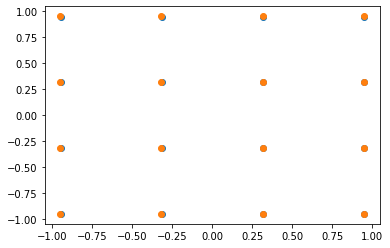

In [368]:
qam_ofdm = Ofdm(QamOfdmEncoder(4), QamOfdmDecoder(4), 28.)
outputs = qam_ofdm.no_noise_outputs()
plt.scatter(cons.real, cons.imag)
plt.scatter(outputs.real, outputs.imag)

In [24]:
qam_ofdm = Ofdm(QamOfdmEncoder(4), QamOfdmDecoder(4), 10)
snrs = range(5, 15)
result = qam_ofdm.test_snrs(dataloader, snrs)
result

100%|█████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.61s/it]


{5: 0.2221040482954545,
 6: 0.17668678977272723,
 7: 0.13931285511363634,
 8: 0.1098845880681818,
 9: 0.08492720170454549,
 10: 0.06639382102272728,
 11: 0.05138849431818182,
 12: 0.040472301136363686,
 13: 0.03222478693181818,
 14: 0.024921874999999982}

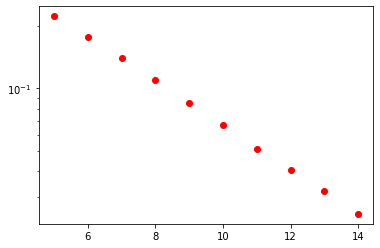

In [25]:
plt.yscale('log')
for x, y in result.items():
    plt.scatter(x, y, color='r')

allCarriers:   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
pilotCarriers: [ 0  8 16 24 32 40 48 56 63]
dataCarriers:  [ 1  2  3  4  5  6  7  9 10 11 12 13 14 15 17 18 19 20 21 22 23 25 26 27
 28 29 30 31 33 34 35 36 37 38 39 41 42 43 44 45 46 47 49 50 51 52 53 54
 55 57 58 59 60 61 62]


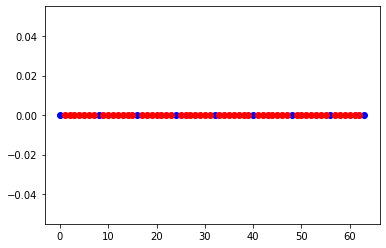

In [77]:
K = 64 # number of OFDM subcarriers
CP = K//4  # length of the cyclic prefix: 25% of the block
P = 8 # number of pilot carriers per OFDM block
pilotValue = 3+3j # The known value each pilot transmits
allCarriers = np.arange(K)  # indices of all subcarriers ([0, 1, ... K-1])

pilotCarriers = allCarriers[::K//P] # Pilots is every (K/P)th carrier.

# For convenience of channel estimation, let's make the last carriers also be a pilot
pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
P = P+1

# data carriers are all remaining carriers
dataCarriers = np.delete(allCarriers, pilotCarriers)

print ("allCarriers:   %s" % allCarriers)
print ("pilotCarriers: %s" % pilotCarriers)
print ("dataCarriers:  %s" % dataCarriers)
plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'bo', label='pilot')
plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'ro', label='data');


# ofdm = Ofdm(0, 0, 0)

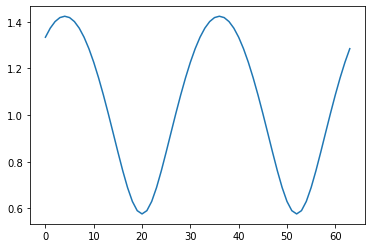

In [78]:
# demapping_table = {v : k for k, v in mapping_table.items()}
channelResponse = np.array([1, 0, 0.3+0.3j])  # the impulse response of the wireless channel
H_exact = np.fft.fft(channelResponse, K)
plt.plot(allCarriers, abs(H_exact))

SNRdb = 50  # signal to noise-ratio in dB at the receiver 


In [79]:
qam_ofdm_encoder = QamOfdmEncoder()
qam_payload = qam_ofdm_encoder(ofdm_train_dataset[0])
qam_numpy = np.array(qam_payload)

In [80]:
def OFDM_symbol(QAM_payload):
    symbol = np.zeros(K, dtype=complex) # the overall K subcarriers
    symbol[pilotCarriers] = pilotValue  # allocate the pilot subcarriers 
    symbol[dataCarriers] = QAM_payload  # allocate the pilot subcarriers
    return symbol
OFDM_data = OFDM_symbol(qam_numpy)
print ("Number of OFDM carriers in frequency domain: ", len(OFDM_data))
OFDM_data[:4]

Number of OFDM carriers in frequency domain:  64


array([ 3.        +3.j        , -0.94868332+0.94868332j,
       -0.94868332+0.31622779j, -0.31622779-0.94868332j])

In [81]:
def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)
OFDM_time = IDFT(OFDM_data)
print ("Number of OFDM samples in time-domain before CP: ", len(OFDM_time))
OFDM_time[:4]

Number of OFDM samples in time-domain before CP:  64


array([ 0.54540147+0.58492995j, -0.061396  +0.06453333j,
        0.068654  +0.12835189j,  0.08632256-0.02737619j])

In [82]:
def addCP(OFDM_time):
    cp = OFDM_time[-CP:]               # take the last CP samples ...
    return np.hstack([cp, OFDM_time])  # ... and add them to the beginning
OFDM_withCP = addCP(OFDM_time)
print ("Number of OFDM samples in time domain with CP: ", len(OFDM_withCP))
OFDM_withCP[10:14]

Number of OFDM samples in time domain with CP:  80


array([-0.13442263+0.06599798j,  0.02634963+0.11048199j,
        0.01187251+0.02921572j,  0.07336626+0.03297247j])

RX Signal power: 0.0652. Noise power: 0.0000


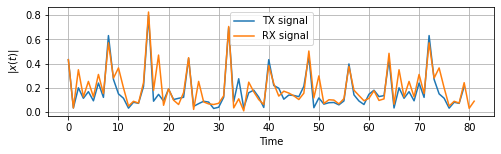

In [83]:
def channel(signal):
    convolved = np.convolve(signal, channelResponse, mode='full')
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10)  # calculate noise power based on signal power and SNR
    
    print ("RX Signal power: %.4f. Noise power: %.4f" % (signal_power, sigma2))
    
    # Generate complex noise with given variance
    # noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))
    noise = 0
    return convolved + noise
OFDM_TX = OFDM_withCP
OFDM_RX = channel(OFDM_TX)
plt.figure(figsize=(8,2))
plt.plot(abs(OFDM_TX), label='TX signal')
plt.plot(abs(OFDM_RX), label='RX signal')
plt.legend(fontsize=10)
plt.xlabel('Time'); plt.ylabel('$|x(t)|$');
plt.grid(True);

In [84]:
def removeCP(signal):
    return signal[CP:(CP+K)]
OFDM_RX_noCP = removeCP(OFDM_RX)
OFDM_RX_noCP[:5]

array([ 0.55432325+0.61382187j, -0.12649738+0.12568081j,
        0.05679546+0.46745131j,  0.04854376-0.02643499j,
        0.17008454+0.08781241j])

In [85]:
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)
OFDM_demod = DFT(OFDM_RX_noCP)
OFDM_demod[:4]

array([ 3.        +4.8j       , -1.5069561 +1.05973068j,
       -1.37188004+0.28615214j, -0.36929162-1.36961591j])

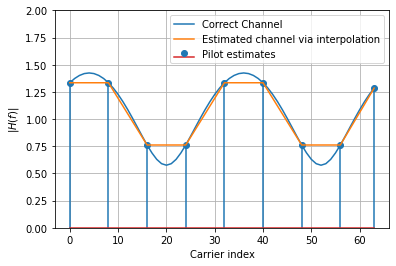

In [86]:
def channelEstimate(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers]  # extract the pilot values from the RX signal
    Hest_at_pilots = pilots / pilotValue # divide by the transmitted pilot values
    
    # Perform interpolation between the pilot carriers to get an estimate
    # of the channel in the data carriers. Here, we interpolate absolute value and phase 
    # separately
    Hest_abs = scipy.interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
    Hest_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)
    
    plt.plot(allCarriers, abs(H_exact), label='Correct Channel')
    plt.stem(pilotCarriers, abs(Hest_at_pilots), label='Pilot estimates')
    plt.plot(allCarriers, abs(Hest), label='Estimated channel via interpolation')
    plt.grid(True); plt.xlabel('Carrier index'); plt.ylabel('$|H(f)|$'); plt.legend(fontsize=10)
    plt.ylim(0,2)
    
    return Hest
Hest = channelEstimate(OFDM_demod)

In [95]:
Hest[:4]

array([1.3       +0.3j       , 1.3149117 +0.22584776j,
       1.32559729+0.15096965j, 1.3320224 +0.07560633j])

In [88]:
def equalize(OFDM_demod, Hest):
    return OFDM_demod / Hest
equalized_Hest = equalize(OFDM_demod, Hest)

In [90]:
equalized_Hest[:4]

array([ 3.        +3.j        , -0.97875079+0.9740421j ,
       -0.99739336+0.32945772j, -0.33452603-1.00923499j])

In [64]:
torch_equalized_hest[10:14]

tensor([ 0.9611-0.4910j, -0.3443+0.3444j, -1.2090-0.1690j, -1.0243+0.4776j],
       dtype=torch.complex128)

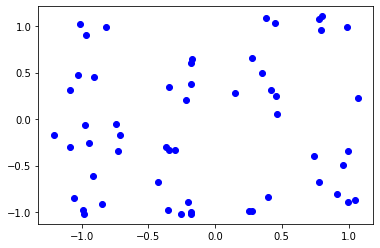

In [65]:
def get_payload(equalized):
    return equalized[dataCarriers]
QAM_est = get_payload(equalized_Hest)
# for real, imag, c in zip(QAM_est.real, QAM_est.imag, color):
    # plt.plot(real, imag, 'o', color=c)
plt.plot(QAM_est.real, QAM_est.imag, 'bo');